In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
from scipy.optimize import curve_fit
import control

# Environment
1. States
2. Transitions
3. Rewards

In [2]:
def create_environment(grid_size, reward_loc, reward_value):
    environment = np.zeros((grid_size[0], grid_size[1]))
    model = np.zeros((grid_size[0], grid_size[1]))
#    model = np.random.rand(grid_size[0], grid_size[1])
    #for i in range(len(environment[:, 0])):
    #    for j in range(len(environment[0, :])):
    #        environment[i][j] = np.linalg.norm(np.array([i, j]) - np.array(reward_loc))
    #environment = (np.max(environment) - environment)/np.max(environment)
    environment[reward_loc[0]][reward_loc[1]] = reward_value
    return environment, model

In [3]:
environment, model = create_environment((100, 100), (90, 90), 10)


In [4]:
def step(environment, curr_pos, action, transition):
    if transition == 0:
        new_pos = np.array(curr_pos) + action
    else:
        new_pos = np.array(curr_pos) + np.dot(np.array(action), np.array([[0, 1], [-1 , 0]]))
        
    if new_pos[0] in range(len(environment[:, 0])) and new_pos[1] in range(len(environment[0, :])):
        reward = environment[new_pos[0]][new_pos[1]]
    else:
        #print ('Here')
        reward = environment[curr_pos[0]][curr_pos[1]]
        new_pos = np.array(curr_pos)
    return new_pos, reward

In [5]:
def select_action(model, curr_pos, visited):
    actions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [-1, -1]])
    #print (curr_pos)
    rewards = list()
    for pick_action in actions:
        new_pos, r = step(model, curr_pos, pick_action, 0)
        #print (visited)
        #print (new_pos.tolist())
        if new_pos.tolist() in visited:
            r = -1
        rewards.append(r)
        #print (r)
    picked_reward = np.random.choice(len(rewards), 1, p = scipy.special.softmax(rewards))
    return actions[picked_reward][0]

In [6]:
def update_model(model, curr_position, new_position, reward, visited):
    model[curr_position[0]][curr_position[1]] = model[curr_position[0]][curr_position[1]] + 0.5*(reward + 0.9*model[new_position[0]][new_position[1]] - model[curr_position[0]][curr_position[1]])
    visited.append(curr_position.tolist())
    return model, visited

In [17]:
curr_pos = np.array([10, 10])
visited = list()
for i in range(300000):
    if i%1000 == 0:
        curr_pos = np.array([10, 10])
    action = select_action(model, curr_pos, visited)
    new_pos, reward = step(environment, curr_pos, action, 0)
    model, visited = update_model(model, curr_pos, new_pos, reward, visited)
    curr_pos = new_pos
    #print (visited)

KeyboardInterrupt: 

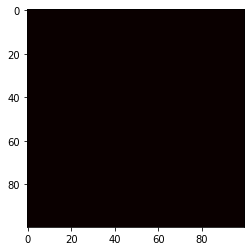

In [18]:
plt.imshow(model, cmap = 'hot')

In [7]:

def calc_angle(current_point, next_point, final_point):
    vec1 = next_point - current_point
    vec2 = final_point - current_point
    vec1 = vec1.astype('float64')
    vec2 = vec2.astype('float64')
    cos_theta = np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))
    theta = np.degrees(np.arccos(cos_theta))
    return theta

def get_partial_traj(data, block, trial, percentage_trajectory):
    traj = get_traj(data, block, trial)
    dist_cutoff = percentage_trajectory*np.sqrt(212**2 + 212**2, dtype = float)
    for i in range(len(traj[0])):
        dist_from_start = np.sqrt(traj[0][i]**2 + traj[1][i]**2, dtype = float)
        if dist_from_start > dist_cutoff:
            break
    partial_trajx = traj[0][:i]
    partial_trajy = traj[1][:i]
        
            
    return partial_trajx, partial_trajy

def get_traj(data, block, trial):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    x_traj = traj['x'][0][trial][0]
    y_traj = traj['y'][0][trial][0]
    return x_traj, y_traj


In [8]:
def calc_curvature_raw(data, block, trial, percentage_trajectory):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    targetx, targety = trajx[-1], trajy[-1]
    partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
    angles = list()
    for i in range(len(partial_trajx[:-1])):
        #print (trajx[i], trajy[i])
        angles.append(calc_angle(np.array([partial_trajx[i], partial_trajy[i]]), np.array([partial_trajx[i+1], partial_trajy[i+1]]), np.array([trajx[-1], trajy[-1]])))
    return angles

# Forming trajectories from distributions

In [9]:
def perceived_required_angle(position, target_position, est_rotation):
    unit_vector_1 = position / np.linalg.norm(position)
    unit_vector_2 = target_position / np.linalg.norm(target_position)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product) + 0.9*est_rotation        
    return angle

In [10]:
def step_angle(curr_pos, angle, sigma, speed, actual_rotation):
    movement_angle = np.random.normal(angle, sigma)
    new_pos = np.zeros(2)
    new_pos[0] = curr_pos[0] + speed*np.cos(movement_angle+actual_rotation)
    new_pos[1] = curr_pos[1] + speed*np.sin(movement_angle+actual_rotation)
    return new_pos

In [11]:
visited = list()
def calc_cost(params, actual_rotation, steps):
    motor_sigma = params[0]
    speed = params[1]
    est_rotation = params[2]
    target = np.array([90, 90])
    curr_pos = np.array([10, 10])
    if motor_sigma < 0:
        return 100000
    if speed < 0:
        return 100000
    if est_rotation < 0:
        return 100000
    for i in range(steps):
        angle = perceived_required_angle(curr_pos, target, est_rotation)

        new_pos = step_angle(curr_pos, angle, motor_sigma, speed, actual_rotation)
        curr_pos = new_pos
        visited.append(curr_pos)
        if np.linalg.norm(np.abs(curr_pos) - np.abs(target)) < 10:
            break
    
    return np.linalg.norm(np.abs(curr_pos) - np.abs(target))

# Control Theory

In [12]:
class LDS:
    def __init__(self, time_steps, ini_state, noise_var, goal):
        self.time_steps = time_steps
        self.ini_state = ini_state
        self.noise_var = noise_var
        self.goal = goal
        
    def dynamics(self, D, B):
        time_states = np.zeros(self.time_steps)
        time_states[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.time_steps)
        for t in range(self.time_steps - 1):
            time_states[t+1] = D*time_states[t] + noise[t]
        return time_states
    def dynamics_openloop(self, D, B, a):
        time_states = np.zeros(self.time_steps)
        time_states[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.time_steps)
        for t in range(self.time_steps - 1):
            time_states[t+1] = D*time_states[t] + B*a[t] + noise[t]
        return time_states
    def dynamics_closedloop(self, params):
        D = params[0]
        B = params[1]
        L = params[2:]
        time_states = np.zeros(self.time_steps)
        time_states[0] = self.ini_state
        noise = np.random.normal(0, self.noise_var, self.time_steps)
        for t in range(self.time_steps - 1):
            a[t] = L[t]*time_states[t]
            time_states[t+1] = D*time_states[t] + B*a[t] + noise[t]
        J = np.sum((time_states - self.goal)**2)
        
        return J, a, time_states
    


In [283]:
# Complete the helper class LQR for LQR

class LQR(LDS):
    def __init__(self, time_steps, ini_state, noise_var, goal):
        super().__init__(time_steps, ini_state, noise_var, goal)
    
    def control_gain_LQR(self, D, B, rho):
        P = np.zeros(self.time_steps) # Riccati updates
        P[-1] = 1  
        
        L = np.zeros(self.time_steps-1) # control gain 
        
        for t in range(self.time_steps-1):
            P[self.time_steps - t - 2] = (1 + 
                            P[self.time_steps - t - 1] * D **2 - 
                            D * P[self.time_steps - t - 1] * B / (
                                rho + P[self.time_steps - t - 1] * B) * B ** 2 * P[self.time_steps - t - 1] * D)

            L[self.time_steps - t - 2] =  -(1 / (rho + P[self.time_steps - t - 1] * B ** 2) * B * P[self.time_steps - t - 1] * D) 
        
        return L


    def calculate_J_state(self, s):
        ###################################################################
        ## Insert your code here to calculate J_state(s).
        ## complete the function and remove
        raise NotImplementedError("Student exercise: Please complete <J_state>")
        ###################################################################
        # J_state = ?

        return J_state 


    def calculate_J_control(self, a):
        ###################################################################
        ## Insert your code here to calculate J_control(s).
        ## complete the function and remove
        raise NotImplementedError("Student exercise: Please complete <J_control> ")
        ###################################################################
        # J_control = ?

        return J_control


In [299]:
class LQR_tracking(LQR):
    def __init__(self, time_steps, ini_state, noise_var, goal):
        super().__init__(time_steps, ini_state, noise_var, goal)

    def dynamics_tracking(self, D, B, L):
        
        s = np.zeros(self.time_steps) # states intialization
        s[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.time_steps)
        
        a = np.zeros(self.time_steps) # control intialization
        a_bar = np.zeros(self.time_steps)
        for t in range(self.time_steps - 1):
            a_bar[t] = ( - D * s[t] + self.goal[t + 1]) / B
            a[t] =  L[t] * (s[t] - self.goal[t]) + a_bar[t]
            s[t + 1] = D * s[t] + B * a[t] + noise[t]
        
        return s, a, a_bar

In [180]:
traj_example = calc_curvature_raw(1004, 5, 10, 1)

In [182]:
L = tracker.control_gain_LQR(0.1, 0.1, 20)
s, a, a_bar = tracker.dynamics_tracking(0.1, 0.1, L)

In [285]:
def track_error(params, traj_example):
    D = params[0]
    B = params[1]
    L = params[2:]
    tracker = LQR_tracking(len(traj_example), traj_example[0], 0.1, traj_example)
    s, a, a_bar = tracker.dynamics_tracking(D, B, L)
    error = np.sum((s - traj_example)**2)
    return error

In [300]:
traj_example = calc_curvature_raw(1024, 5, 10, 1)
x0 = [0.1, 0.1]
L0 = np.zeros(len(traj_example))
x0.extend(L0.tolist())
fits = scipy.optimize.basinhopping(track_error, x0, minimizer_kwargs={"args":traj_example, "method":"Nelder-Mead"})
B = fits.x[0]
D = fits.x[1]
L = fits.x[2:]
tracker = LQR_tracking(len(traj_example), traj_example[0], 0.1, traj_example)
s, a, a_bar = tracker.dynamics_tracking(D, B, L)

array([-1.20344786e+00, -3.75838923e+00,  2.28508102e+00,  9.66781343e-01,
       -7.88114158e+00,  2.04780356e+00,  2.99898324e+00, -7.53696033e+00,
       -3.43647264e-03, -1.05793417e+00, -1.46292301e+00,  1.47368011e+00,
       -2.98117317e+00,  6.62630235e-01,  2.69519293e+00, -3.93605670e-01,
       -1.25089438e+00,  7.11746113e+00,  1.26013064e+00,  8.07965824e-01,
        1.64067639e-01,  1.56913070e+00,  1.23133507e+00])

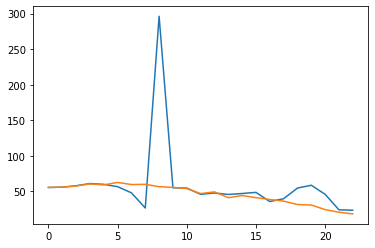

In [303]:
plt.plot(s)
plt.plot(traj_example)
L

# Using the control library
